In [44]:
# SQL
import sqlite3
# Data Manipulation
import numpy as np
import pandas as pd
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
#preprocessing libraries
from sklearn.preprocessing import LabelEncoder, StandardScaler, Imputer, OneHotEncoder
from imblearn.over_sampling import SMOTE

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#load data (make sure you have downloaded database.sqlite)
with sqlite3.connect(r'C:/Users/ernest.chocholowski/Desktop/Datasets/Soccer/database.sqlite') as con:
    country_df = pd.read_sql_query("SELECT * from Country", con)
    matches_df = pd.read_sql_query("SELECT * from Match", con)
    league_df = pd.read_sql_query("SELECT * from League", con)
    team_df = pd.read_sql_query("SELECT * from Team", con)
    player_df = pd.read_sql_query("select * from Player", con)
    player_stats_df = pd.read_sql_query("select * from player_attributes", con)

#load past results
super_table=[["Name", 'Regression function', "Train Acc", 'Validation Acc', "r2_score", "conf_matrix", 'Cross-Valid.'],]
df_load = pd.read_csv(r'C:/Users/ernest.chocholowski/Desktop/GIT/SoccerAnalysis/out/results_table.csv')
for row in df_load.values.tolist():
    super_table.append(row)

all_df = [country_df, matches_df, league_df, team_df, player_df]
country_df.dfname = 'country_df'
matches_df.dfname = 'matches_df'
league_df.dfname = 'league_df' 
team_df.dfname = 'team_df' 
player_df.dfname = 'player_df'
player_stats_df.dfname = 'player_stats_df'

#FREAKING CHEATING NO WAITING SO GOOD
matches_df = pd.DataFrame().from_csv('saved_matches_df')

def reduce_dim (matches_df):
    #CREATE SHORT_DF
    short_df = matches_df[['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA',   #
           'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA',    # bookkeepers
           'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA',    #
           'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA',                         #
            'home_player_1_overall_rating', 'away_player_1_overall_rating',        # goalkeepers
            'home_defenders_score', 'home_midfielders_score', 'home_forwarders_score',  #team roles
            'away_defenders_score', 'away_midfielders_score', 'away_forwarders_score',  #comparison
            'home_player_2_Age', 'home_player_3_Age', 'home_player_4_Age', #
           'home_player_5_Age', 'home_player_6_Age', 'home_player_7_Age',  #
           'home_player_8_Age', 'home_player_9_Age', 'home_player_10_Age', #
           'home_player_11_Age', 'away_player_2_Age',                      # AGES
           'away_player_3_Age', 'away_player_4_Age', 'away_player_5_Age',  #
           'away_player_6_Age', 'away_player_7_Age', 'away_player_8_Age',  #
           'away_player_9_Age', 'away_player_10_Age', 'away_player_11_Age']]# #OTHER STATS?

    #GET MEAN AGE FOR BOTH TEAM - EXCLUDING GOALKEEPER, FOR REASONS
    short_df['Age_home'] = short_df[['home_player_2_Age', 'home_player_3_Age', 'home_player_4_Age', 
          'home_player_5_Age', 'home_player_6_Age', 'home_player_7_Age',
          'home_player_8_Age', 'home_player_9_Age', 'home_player_10_Age', 
          'home_player_11_Age']].mean(axis=1)
    short_df['Age_away'] = short_df[['away_player_2_Age',
          'away_player_3_Age', 'away_player_4_Age', 'away_player_5_Age',  
          'away_player_6_Age', 'away_player_7_Age', 'away_player_8_Age',  
          'away_player_9_Age', 'away_player_10_Age', 'away_player_11_Age']].mean(axis=1)
    
    #WE DON'T NEED AGES ANYMORE
    short_df.drop(['home_player_2_Age', 'home_player_3_Age', 'home_player_4_Age', 
           'home_player_5_Age', 'home_player_6_Age', 'home_player_7_Age',
           'home_player_8_Age', 'home_player_9_Age', 'home_player_10_Age', 
           'home_player_11_Age', 'away_player_2_Age',
           'away_player_3_Age', 'away_player_4_Age', 'away_player_5_Age',  
           'away_player_6_Age', 'away_player_7_Age', 'away_player_8_Age',  
           'away_player_9_Age', 'away_player_10_Age', 'away_player_11_Age'], inplace = True, axis=1)
   # short_df['AgeCatHome'] = pd.cut(short_df['Age_home'], 10)
   # short_df['AgeCatAway'] = pd.cut(short_df['Age_away'], 10)
    #BOOKKEEPERS MEAN FOR EACH MATCH
    bookies = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
    bookies_H = [bookie+'H' for bookie in bookies]
    bookies_A = [bookie+'A' for bookie in bookies]
    bookies_D = [bookie+'D' for bookie in bookies]
    bookies_types = {'Home_odds':bookies_H, 'Draw_odds':bookies_D, 'Away_odds':bookies_A}
    for feature_name, feature_list in bookies_types.items():
        short_df[feature_name] = short_df[feature_list].mean(axis=1)
        short_df.drop(feature_list, inplace = True, axis=1)
        
    #Categorize elos
    elo_cats = [-1,]
    for i in range(1050,2200,50):
        elo_cats.append(i)
    short_df['elo_home_cat'] = pd.cut(matches_df['elo_home'], bins=elo_cats, labels=False)
    short_df['elo_away_cat'] = pd.cut(matches_df['elo_away'], bins=elo_cats, labels=False)
    
    #Categorize expects
    #short_df['NoBonus_cat'] = pd.cut(matches_df['nobonus_expect_elo'], bins=10, labels=False)
    #short_df['100Bonus_cat'] = pd.cut(matches_df['100bonus_expect_elo'], bins=10, labels=False)
    #short_df['200Bonus_cat'] = pd.cut(matches_df['200bonus_expect_elo'], bins=10, labels=False)
    
    #OTHERS
    short_df['home_formation'] = matches_df['home_formation']
    short_df['away_formation'] = matches_df['away_formation']
    short_df['NoBonus'] = matches_df['nobonus_expect_elo']
    short_df['100Bonus'] = matches_df['100bonus_expect_elo']
    short_df['200Bonus'] = matches_df['200bonus_expect_elo']
    short_df['VSPointDiff'] = matches_df['VSPointDiff']
    short_df['entropy'] = matches_df['entropy']
    short_df['RESULT'] = matches_df['RESULT']
        
    return short_df

short_df = reduce_dim(matches_df)
ml_matches_df = short_df

#labelling
results = {'WIN': 1, 'DRAW': 0, 'LOSE': -1, 1:1, 0:0, -1:-1}
ml_matches_df['RESULT']=ml_matches_df['RESULT'].map(results)

le = LabelEncoder()
for col in ml_matches_df.columns.values:
   # Encoding only categorical variables
    if ml_matches_df[col].dtypes=='object':
   # Using whole data to form an exhaustive list of levels
        data=ml_matches_df[col].append(ml_matches_df[col])
        le.fit(data.values)
        ml_matches_df[col]=le.transform(ml_matches_df[col])

NoScalling = ['RESULT']#, 'NoBonus', '100Bonus', '200Bonus']
#scale Features
scaled_features = StandardScaler(with_mean=True, with_std=True)\
                                .fit_transform(ml_matches_df.drop(NoScalling, axis=1).values)
scaled_features_df = pd.DataFrame(scaled_features, index=ml_matches_df.drop(NoScalling, axis=1).index, 
                                  columns=ml_matches_df.drop(NoScalling, axis=1).columns)

scaled_features_df[NoScalling] = ml_matches_df[NoScalling]

scaled_features_df.head()

In [28]:
valid = scaled_features_df.sample(frac=0.2, random_state=1)
train = scaled_features_df[~scaled_features_df.isin(valid.to_dict('l')).all(1)]

In [29]:
WIN = train[train['RESULT'] == 1]
DRAW = train[train['RESULT'] == 0]
LOSE = train[train['RESULT'] == -1]

In [30]:
print("WIN_LEN:",len(WIN))
print("DRAW_LEN:",len(DRAW))
print("LOSE_LEN:",len(LOSE))

WIN_LEN: 5089
DRAW_LEN: 2845
LOSE_LEN: 3150


In [31]:
WIN.head()

,home_player_1_overall_rating,away_player_1_overall_rating,home_defenders_score,home_midfielders_score,home_forwarders_score,away_defenders_score,away_midfielders_score,away_forwarders_score,Age_home,Age_away,Away_odds,Home_odds,Draw_odds,elo_home_cat,elo_away_cat,home_formation,away_formation,NoBonus,100Bonus,200Bonus,VSPointDiff,entropy,RESULT
9531,-0.045861,0.224695,-1.221238,0.991310,0.085073,0.912986,0.308791,-1.179658,-0.029473,-0.502648,-0.968220,3.736614,1.141530,0.062927,3.930793,0.990026,0.951837,-1.900825,-2.322785,-2.853217,-1.050839,-1.332724,1
7635,-0.635645,-1.088259,-1.034522,-1.365801,0.783755,0.631466,0.665436,0.078982,0.008828,0.450136,-0.841046,1.436654,-0.150351,0.062927,3.278548,-0.648038,-0.659403,-1.807125,-2.161868,-2.570520,-1.050839,0.136385,1
18426,-0.635645,-0.942375,1.019352,-0.809878,-1.382160,1.100666,-0.671983,-0.969885,-0.795492,-1.531654,-0.988494,4.669693,0.903476,-0.915361,3.278548,0.990026,-0.659403,-1.925444,-2.365994,-2.931879,-0.264738,-1.630796,1
12886,-0.930536,-1.963561,-0.661090,-1.310209,0.224809,-0.338213,-0.894887,-1.074771,0.736546,1.669699,-0.927710,3.164844,0.279047,0.062927,3.278548,-3.105134,-2.270643,-1.768392,-2.096938,-2.460820,-2.098975,-0.749777,1
9291,0.691369,0.224695,0.365847,-0.609746,0.713886,0.068427,-0.961758,-0.340564,-0.412482,-0.540759,-0.897603,1.957735,0.153177,-1.567554,2.952425,0.990026,0.951837,-1.956004,-2.420180,-3.032249,-0.002704,-0.252803,1


In [32]:
#gets a random 50% of the entire set
WIN_one = WIN.sample(frac=0.5, random_state=1)
#gets the left out portion of the dataset
WIN_two = WIN[~WIN.isin(WIN_one.to_dict('l')).all(1)]

In [33]:
WIN_one.describe()

,home_player_1_overall_rating,away_player_1_overall_rating,home_defenders_score,home_midfielders_score,home_forwarders_score,away_defenders_score,away_midfielders_score,away_forwarders_score,Age_home,Age_away,Away_odds,Home_odds,Draw_odds,elo_home_cat,elo_away_cat,home_formation,away_formation,NoBonus,100Bonus,200Bonus,VSPointDiff,entropy,RESULT
count,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.000000,2544.0
mean,-0.003609,0.005066,0.011975,0.050339,-0.001892,-0.014967,-0.003416,0.020300,-0.021463,-0.015530,0.296349,-0.304864,0.172166,0.212901,-0.196119,-0.003501,0.023664,0.281485,0.280583,0.276267,0.428869,-0.199565,1.0
std,1.002930,1.013292,0.997352,1.030079,1.007802,0.983184,1.007259,0.999184,0.997431,0.986909,1.121731,0.623448,1.156182,1.042497,0.909108,0.989340,1.007113,0.960985,0.911859,0.862002,0.890217,1.124799,0.0
min,-3.437118,-3.422398,-3.368470,-4.062024,-4.107020,-4.342050,-4.572792,-4.116485,-3.591460,-3.513444,-0.991303,-0.987477,-1.982485,-2.871939,-2.917782,-3.105134,-3.076262,-1.956004,-2.420180,-3.032249,-2.885076,-4.894877,1.0
25%,-0.635645,-0.650607,-0.661090,-0.609746,-0.648544,-0.682293,-0.644121,-0.550338,-0.527385,-0.464537,-0.453870,-0.710866,-0.521294,-0.589265,-0.961046,-0.648038,-0.659403,-0.439101,-0.311804,-0.171117,-0.002704,-0.807330,1.0
50%,-0.045861,-0.067073,-0.007585,-0.031587,-0.019730,-0.025413,-0.025564,-0.025904,0.008828,0.030911,-0.101459,-0.444353,-0.293484,0.062927,-0.308801,0.170994,0.146217,0.314962,0.424400,0.490367,0.521364,0.259018,1.0
75%,0.543923,0.516462,0.645921,0.774500,0.609084,0.631466,0.665436,0.603416,0.545041,0.526358,0.731836,-0.127106,0.429281,1.041216,0.343444,0.990026,0.951837,1.088773,1.042560,0.962545,1.045431,0.683969,1.0
max,2.313275,2.267067,2.699795,3.192762,2.670196,2.977465,3.451728,2.596263,3.455913,3.499043,10.283902,5.009888,9.070227,3.323889,3.278548,2.628090,2.563077,2.034635,1.659209,1.373320,3.141702,0.850370,1.0


In [34]:
WIN_two.describe()

,home_player_1_overall_rating,away_player_1_overall_rating,home_defenders_score,home_midfielders_score,home_forwarders_score,away_defenders_score,away_midfielders_score,away_forwarders_score,Age_home,Age_away,Away_odds,Home_odds,Draw_odds,elo_home_cat,elo_away_cat,home_formation,away_formation,NoBonus,100Bonus,200Bonus,VSPointDiff,entropy,RESULT
count,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.000000,2545.0
mean,-0.021702,0.021031,0.026591,-0.038977,-0.020993,-0.006739,-0.009374,0.016792,-0.002068,-0.012247,0.388381,-0.322232,0.271285,0.284724,-0.221664,-0.048809,0.019597,0.350397,0.342457,0.330589,0.475649,-0.283044,1.0
std,1.001627,1.031403,0.984511,0.993138,0.994713,0.983744,1.005309,0.975485,1.007634,1.010785,1.248762,0.647672,1.300008,1.063684,0.895468,1.015087,0.999157,0.963873,0.907340,0.852502,0.912583,1.192952,0.0
min,-3.437118,-3.422398,-3.648544,-3.895247,-4.107020,-4.342050,-3.681178,-4.326258,-3.514858,-3.513444,-0.996920,-1.004001,-1.554179,-2.871939,-2.917782,-3.105134,-3.076262,-1.925444,-2.365994,-2.931879,-2.623042,-4.894540,1.0
25%,-0.635645,-0.650607,-0.567732,-0.698694,-0.683478,-0.588453,-0.671983,-0.550338,-0.527385,-0.502648,-0.435986,-0.731089,-0.503812,-0.589265,-0.961046,-0.648038,-0.659403,-0.382598,-0.251090,-0.111806,-0.002704,-0.939160,1.0
50%,-0.045861,-0.067073,-0.007585,-0.076061,-0.054664,0.068427,-0.003273,-0.025904,0.047129,0.030911,-0.063785,-0.463771,-0.245409,0.062927,-0.308801,0.170994,0.146217,0.413057,0.509614,0.559536,0.521364,0.202521,1.0
75%,0.543923,0.662346,0.645921,0.607723,0.609084,0.631466,0.693299,0.603416,0.545041,0.526358,0.847233,-0.148978,0.577658,1.041216,0.343444,0.990026,0.951837,1.140221,1.079648,0.988829,1.045431,0.666869,1.0
max,2.313275,2.267067,3.446659,2.942597,2.740064,3.258984,3.200962,2.491376,3.187806,3.537155,9.351820,5.047687,9.318524,3.649985,3.930793,2.628090,2.563077,2.042656,1.663905,1.376247,3.141702,0.847636,1.0


In [35]:
WINvsDRAW = pd.concat([WIN_one, DRAW])
WINvsLOSE = pd.concat([WIN_two, LOSE])
DRAWvsLOSE = pd.concat([DRAW, LOSE])

In [40]:
WINvsDRAW.describe()

,home_player_1_overall_rating,away_player_1_overall_rating,home_defenders_score,home_midfielders_score,home_forwarders_score,away_defenders_score,away_midfielders_score,away_forwarders_score,Age_home,Age_away,Away_odds,Home_odds,Draw_odds,elo_home_cat,elo_away_cat,home_formation,away_formation,NoBonus,100Bonus,200Bonus,VSPointDiff,entropy,RESULT
count,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000
mean,0.003771,0.012975,-0.003929,0.028500,0.005779,-0.005618,-0.003437,-0.003061,0.004841,0.003160,0.065269,-0.141936,-0.008345,0.064137,-0.078415,-0.018984,-0.007163,0.097156,0.104115,0.109516,0.133977,-0.004206,0.472073
std,0.995286,1.001199,0.994467,1.019390,1.010374,0.992907,1.005296,1.005806,0.993278,0.987702,0.973506,0.790586,0.970616,0.994753,0.958140,1.004721,1.027974,0.968939,0.950232,0.927489,0.937075,0.990364,0.499266
min,-3.437118,-3.422398,-3.897499,-4.062024,-4.107020,-4.342050,-4.572792,-4.745805,-3.591460,-3.513444,-1.034685,-0.987477,-1.982485,-2.871939,-2.917782,-3.105134,-3.076262,-1.966998,-2.439825,-3.069121,-3.147110,-4.894877,0.000000
25%,-0.635645,-0.650607,-0.661090,-0.643102,-0.683478,-0.588453,-0.671983,-0.620262,-0.489084,-0.464537,-0.532459,-0.620715,-0.546970,-0.589265,-0.634924,-0.648038,-0.659403,-0.667480,-0.567720,-0.431777,-0.526772,-0.393980,0.000000
50%,-0.045861,-0.067073,-0.007585,-0.059383,-0.019730,-0.025413,-0.058999,-0.060867,0.047129,0.030911,-0.257875,-0.325555,-0.349316,0.062927,-0.308801,0.170994,0.146217,0.085658,0.216397,0.315498,0.259330,0.417662,0.000000
75%,0.543923,0.516462,0.645921,0.746704,0.644018,0.631466,0.665436,0.603416,0.545041,0.526358,0.339942,0.018852,0.130519,0.715120,0.669567,0.990026,0.951837,0.879615,0.886984,0.849899,0.783397,0.719728,1.000000
max,2.313275,2.267067,2.699795,3.192762,2.809933,2.977465,3.451728,2.596263,3.455913,3.537155,10.283902,9.093953,9.070227,3.976082,3.278548,2.628090,2.563077,2.034635,1.659209,1.373320,3.141702,0.850370,1.000000


In [41]:
WINvsLOSE.describe()

,home_player_1_overall_rating,away_player_1_overall_rating,home_defenders_score,home_midfielders_score,home_forwarders_score,away_defenders_score,away_midfielders_score,away_forwarders_score,Age_home,Age_away,Away_odds,Home_odds,Draw_odds,elo_home_cat,elo_away_cat,home_formation,away_formation,NoBonus,100Bonus,200Bonus,VSPointDiff,entropy,RESULT
count,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000,5695.000000
mean,0.001700,0.003679,-0.000234,-0.021457,-0.012706,-0.011025,0.000650,-0.003325,0.002137,0.001707,-0.051133,0.125964,0.017144,-0.042832,0.070807,0.006468,-0.002882,-0.076377,-0.084209,-0.090416,-0.123023,-0.008261,-0.106234
std,1.009134,1.010972,1.001710,0.985691,0.987516,1.000755,0.993776,0.991195,1.010307,1.015102,1.023640,1.141427,1.025239,1.008592,1.033306,0.994210,0.986675,1.025873,1.038432,1.053332,1.051491,1.008748,0.994429
min,-3.437118,-3.422398,-4.675481,-4.478966,-5.783857,-4.342050,-3.792630,-4.326258,-3.668062,-3.818335,-1.041856,-1.004001,-2.268659,-2.871939,-2.917782,-3.105134,-3.076262,-1.979061,-2.461474,-3.110058,-3.147110,-4.894540,-1.000000
25%,-0.635645,-0.650607,-0.661090,-0.676457,-0.648544,-0.588453,-0.671983,-0.620262,-0.527385,-0.502648,-0.671657,-0.555700,-0.530581,-0.589265,-0.634924,-0.648038,-0.659403,-0.929610,-0.884014,-0.779860,-0.788806,-0.388616,-1.000000
50%,-0.045861,-0.067073,-0.007585,-0.059383,-0.054664,0.037147,-0.003273,-0.060867,0.047129,0.030911,-0.374479,-0.217773,-0.335549,-0.263169,0.017322,0.170994,0.146217,-0.103743,0.034618,0.155256,-0.264738,0.429742,-1.000000
75%,0.543923,0.516462,0.645921,0.607723,0.609084,0.631466,0.693299,0.603416,0.545041,0.526358,0.146789,0.352945,0.138181,0.389023,0.669567,0.990026,0.951837,0.758237,0.793006,0.779921,0.521364,0.721761,1.000000
max,2.313275,2.267067,3.446659,3.025985,2.740064,3.634344,3.563180,3.225583,3.647418,3.613378,9.351820,10.363366,9.318524,3.649985,3.930793,2.628090,2.563077,2.042656,1.663905,1.376247,3.141702,0.848297,1.000000


In [42]:
DRAWvsLOSE.describe()

,home_player_1_overall_rating,away_player_1_overall_rating,home_defenders_score,home_midfielders_score,home_forwarders_score,away_defenders_score,away_midfielders_score,away_forwarders_score,Age_home,Age_away,Away_odds,Home_odds,Draw_odds,elo_home_cat,elo_away_cat,home_formation,away_formation,NoBonus,100Bonus,200Bonus,VSPointDiff,entropy,RESULT
count,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000,5995.000000
mean,0.015749,0.004081,-0.020125,0.000421,0.002839,-0.006311,0.002957,-0.021653,0.016367,0.016251,-0.280535,0.258237,-0.179441,-0.194251,0.174100,0.011286,-0.027539,-0.253420,-0.250850,-0.245023,-0.380347,0.193216,-0.525438
std,1.002415,0.992373,1.004010,0.993840,0.996574,1.008325,0.993572,1.007215,1.001518,1.004248,0.691297,1.157367,0.696598,0.910270,1.044663,0.996504,1.009736,0.959997,1.002089,1.040794,0.928252,0.786990,0.499394
min,-3.437118,-3.422398,-4.675481,-4.478966,-5.783857,-4.154370,-3.792630,-4.745805,-3.668062,-3.818335,-1.041856,-0.969225,-2.268659,-2.871939,-2.917782,-3.105134,-3.076262,-1.979061,-2.461474,-3.110058,-3.147110,-3.805125,-1.000000
25%,-0.635645,-0.650607,-0.661090,-0.676457,-0.683478,-0.588453,-0.644121,-0.620262,-0.489084,-0.464537,-0.716552,-0.429922,-0.554801,-0.915361,-0.634924,-0.648038,-0.659403,-1.062852,-1.054951,-0.981186,-1.050839,-0.072033,-1.000000
50%,-0.045861,-0.067073,-0.007585,-0.059383,-0.019730,-0.025413,-0.025564,-0.130791,0.085430,0.030911,-0.460089,-0.109666,-0.389088,-0.263169,0.017322,0.170994,0.146217,-0.302405,-0.166599,-0.030799,-0.264738,0.519282,-1.000000
75%,0.543923,0.516462,0.645921,0.635519,0.609084,0.631466,0.693299,0.603416,0.583342,0.564470,-0.118200,0.509164,-0.066265,0.389023,0.995689,0.990026,0.951837,0.481267,0.567603,0.605820,0.259330,0.746581,0.000000
max,2.313275,2.267067,3.197704,3.025985,2.809933,3.634344,3.563180,3.225583,3.647418,3.613378,5.088117,10.363366,5.799666,3.976082,3.930793,2.628090,2.563077,2.019077,1.650077,1.367619,3.141702,0.848297,0.000000


In [53]:
# machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

#Split data for train and test
def split_data(data, targ):
    #set target for training
    target = data[targ]

    # Import the train_test_split method
    from sklearn.model_selection import train_test_split
    # Split data into train (3/4th of data) and test (1/4th of data)
    return train_test_split(data.drop('RESULT', axis=1), target, train_size = 0.75, random_state=0);

def regr_equation(logreg, train, target):
    if type(model) is LogisticRegression:
        coef = logreg.coef_[0]
        intercept = "{:.2f}".format(logreg.intercept_[0])
    else:
        coef = logreg.coef_
        intercept = "{:.2f}".format(logreg.intercept_)
    try:    
        output = target.name + ' = ' + str(intercept) + ' + '
    except:
        output = 'TARGET' + ' = ' + str(intercept) + ' + '
    coeff_df = pd.DataFrame(train.columns.delete(0))
    coeff_df.columns = ['Feature']
    coeff_df["Correlation"] = pd.Series(logreg.coef_[0])
    features = coeff_df['Feature'].tolist()
    coefficients = coeff_df['Correlation'].tolist()
    
    for coeff, feature in zip(coefficients, features):
        coeff_str = "{:.2f}".format(coeff)
        output += coeff_str + "*" + str(feature) + " + "
    return output[:-3]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
def conf_matrix_str (conf, normalize=True):
    if normalize:
            conf = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]

  #  conf_matrix = 'Pred \tLose\tDraw\tWin\n'+\
  #                'True \n'+\
  #                'Lose \t{:.2f}\t{:.2f}\t{:.2f}\n'.format(conf[0][0], conf[0][1], conf[0][2])+\
  #                'Draw \t{:.2f}\t{:.2f}\t{:.2f}\n'.format(conf[1][0], conf[1][1], conf[1][2])+\
  #                'Win \t{:.2f}\t{:.2f}\t{:.2f}'.format(conf[2][0], conf[2][1], conf[2][2])
    return conf

def test_model (model, data, target, submission_name = None, test=None, cross_valid=True):
   
    if test is None:
        from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
        train, test, target_train, target_test = data
        model.fit(train, target_train)
        #Calc parameters
        if type(model) is LogisticRegression:
            function_str = regr_equation(model, train, target_train)
        elif type(model) is LinearRegression:
            function_str = regr_equation(model, train, target_train)
        else :
            function_str = "NA"    

        if type(model) is not LinearRegression:
            trainset_acc = round(accuracy_score(target_train, model.predict(train)) * 100, 2)
            testset_acc = round(accuracy_score(target_test, model.predict(test)) * 100, 2)
            confusion_matrix = confusion_matrix(target_test, model.predict(test))
            conf_matrix = conf_matrix_str(confusion_matrix)
                    
        else:
            trainset_acc = 'NA'
            testset_acc = 'NA'
            conf_matrix = "NA"

        r2_score = r2_score(target_train, model.predict(train))
        kaggle = "not_tested"
        
          #Perform k-fold cross-validation with 5 folds
        if cross_valid == True:
            from sklearn.cross_validation import KFold   #For K-fold cross validation
            X=pd.concat([train,test])
            Y=pd.concat([target_train, target_test])
            data_df = pd.concat([X,Y], axis=1)
            kf = KFold(data_df.shape[0], n_folds=5)
            error = []
            predictors = list(data_df.columns.values)
            del predictors[-1]
            for train, test in kf:
                # Filter training data
                train_predictors = (data_df[predictors].iloc[train,:])

                # The target we're using to train the algorithm.
                train_target = data_df[target].iloc[train]

                # Training the algorithm using the predictors and target.
                model.fit(train_predictors, train_target)

                #Record error from each cross-validation run
                error.append(model.score(data_df[predictors].iloc[test,:], data_df[target].iloc[test]))
        else:
            error=[0,0]
        #Fit the model again so that it can be refered
        #prints
        print("-"*40)
        print('Submission name:', submission_name )
        print('Regression function:\n', function_str)
        print('Accuracy on train set:', trainset_acc,"%")
        print('Accuracy on test set:', testset_acc,"%")
        print ("Cross-Validation Score : %s" % "{0:.3%}".format(np.mean(error)))
        print("R2 score:", r2_score)
        print("Confusion matrix:\n", conf_matrix)
        if submission_name[:3] == "WvD":
            classes=['Draw','Win']
        elif submission_name[:3] == "WvL":
            classes=['Lose','Win']
        elif submission_name[:3] == "DvL":
            classes=['Lose','Draw']
        else:
            classes=['Lose', 'Draw','Win']
        plot_confusion_matrix(confusion_matrix, classes=classes,
                              normalize=True, title = 'Confusion matrix '+submission_name, cmap=plt.cm.Blues)
        return [submission_name, function_str, str(trainset_acc), str(testset_acc), r2_score, conf_matrix, np.mean(error)]

In [91]:
#Setup
suffix = '_shortECH_elo{No,100,200}_SCALED_ResCorr'
modelMLP = MLPClassifier(hidden_layer_sizes=(104, 104, 104), activation='logistic', solver='sgd', alpha=0.0001, 
                         batch_size='auto', learning_rate='adaptive', learning_rate_init=1, power_t=0.5, 
                         max_iter=2000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, 
                         momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, 
                         beta_1=0.9, beta_2=0.999, epsilon=1e-08)

modelLogReg = LogisticRegression(n_jobs = -1, class_weight=None)
modelLogReg_balanced = LogisticRegression(n_jobs = -1, class_weight='balanced')

modelLinReg = LinearRegression()
modelSVC = SVC()
modellinSVC = LinearSVC()
modelKN = KNeighborsClassifier(n_neighbors = 3)
modelGNB = GaussianNB()
modelPercp = Perceptron()
modelSGD = SGDClassifier()

modelRndForest = RandomForestClassifier(n_estimators=800, criterion='gini', max_depth=15, min_samples_split=20, 
                                        min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                                        max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False,
                                        n_jobs=-1, random_state=None, verbose=0, warm_start=False, class_weight=None)
modelRndForest_balanced = RandomForestClassifier(n_estimators=800, criterion='gini', max_depth=15, min_samples_split=20, 
                                        min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                                        max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False,
                                        n_jobs=-1, random_state=None, verbose=0, warm_start=False, 
                                        class_weight='balanced')

modelXTree = ExtraTreesClassifier(n_estimators=800, criterion='gini', max_depth=None, min_samples_split=16, 
                                  min_samples_leaf=5, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                                  max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=False, oob_score=False, 
                                  n_jobs=-1, random_state=None, verbose=0, warm_start=False, class_weight=None)
modelXTree_balanced = ExtraTreesClassifier(n_estimators=800, criterion='gini', max_depth=None, min_samples_split=16, 
                                  min_samples_leaf=5, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                                  max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=False, oob_score=False, 
                                  n_jobs=-1, random_state=None, verbose=0, warm_start=False, class_weight='balanced')

modelGBRT = GradientBoostingClassifier()
 

models = {
          modelRndForest: "RandomForest",
          modelLogReg : "logreg",
          modelXTree : 'xTrees',
          modelRndForest_balanced: "RandomForest_balanced",
          modelLogReg_balanced : "logreg_balanced",
          modelXTree_balanced : 'xTrees_balanced',
          modelGBRT: "GradientBoosting",
          modelSVC : "SVC",
          modellinSVC: "linSVC",
          modelSGD : "SGD",
          modelGNB: "GNB",
          modelKN: "KNN"
         }

In [180]:
trainWD, testWD, target_trainWD, target_testWD = split_data(WINvsDRAW, 'RESULT')
dataWD = (trainWD, testWD, target_trainWD, target_testWD)

trainWL, testWL, target_trainWL, target_testWL = split_data(WINvsLOSE, 'RESULT')
dataWL = (trainWL, testWL, target_trainWL, target_testWL)

trainDL, testDL, target_trainDL, target_testDL = split_data(DRAWvsLOSE, 'RESULT')
dataDL = (trainDL, testDL, target_trainDL, target_testDL)

_data = {
    'WvD_' : dataWD, 
    'WvL_' : dataWL, 
    'DvL_' : dataDL
    }

37.46
Normalized confusion matrix
[[ 0.          0.66582756  0.33417244]
 [ 0.          0.68091168  0.31908832]
 [ 0.          0.49608764  0.50391236]]


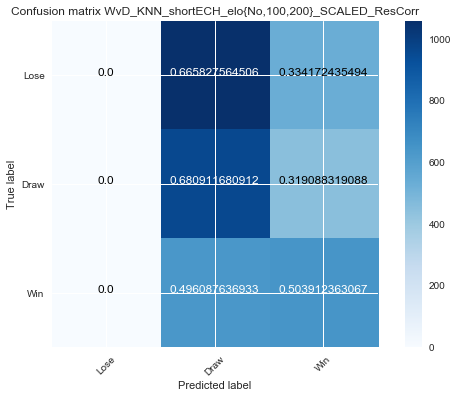

42.17
Normalized confusion matrix
[[ 0.          0.82693518  0.17306482]
 [ 0.          0.74074074  0.25925926]
 [ 0.          0.40453834  0.59546166]]


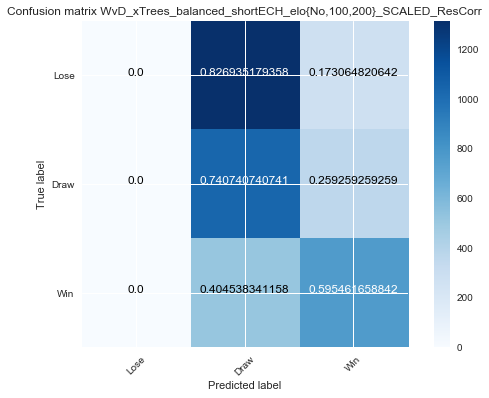

43.57
Normalized confusion matrix
[[ 0.          0.84078037  0.15921963]
 [ 0.          0.79131054  0.20868946]
 [ 0.          0.41314554  0.58685446]]


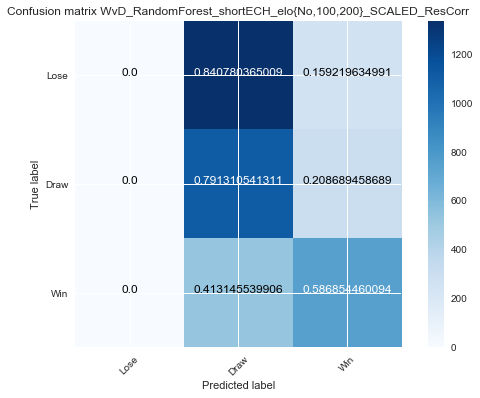

40.37
Normalized confusion matrix
[[ 0.          0.83008181  0.16991819]
 [ 0.          0.65527066  0.34472934]
 [ 0.          0.37089202  0.62910798]]


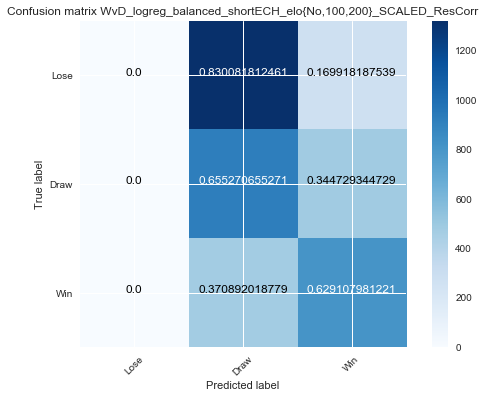

40.08
Normalized confusion matrix
[[ 0.          0.85147892  0.14852108]
 [ 0.          0.74216524  0.25783476]
 [ 0.          0.47574335  0.52425665]]


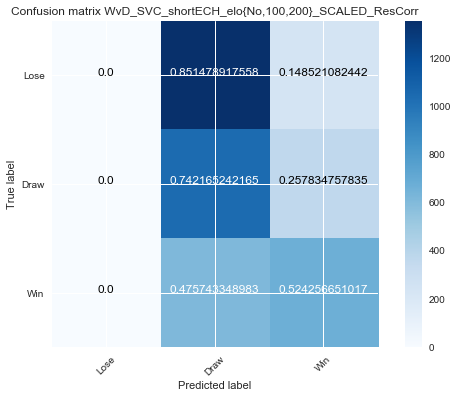

38.91
Normalized confusion matrix
[[ 0.          0.8653241   0.1346759 ]
 [ 0.          0.73290598  0.26709402]
 [ 0.          0.50469484  0.49530516]]


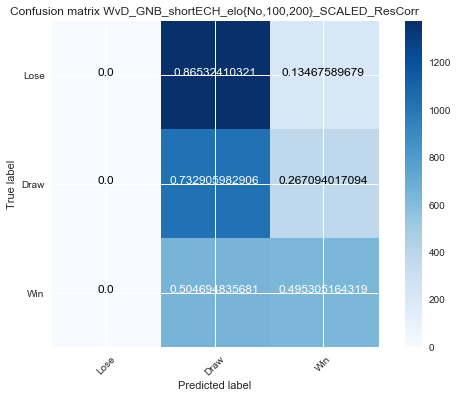

36.31
Normalized confusion matrix
[[ 0.          0.70358716  0.29641284]
 [ 0.          0.57621083  0.42378917]
 [ 0.          0.41940532  0.58059468]]


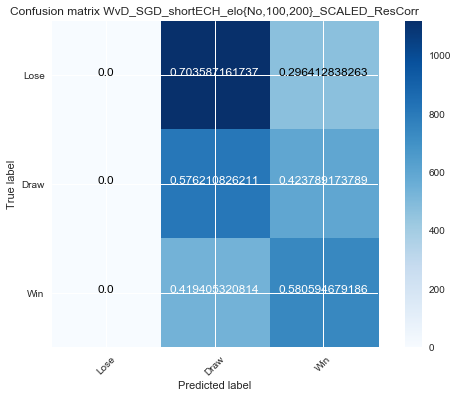

41.11
Normalized confusion matrix
[[ 0.          0.83637508  0.16362492]
 [ 0.          0.68376068  0.31623932]
 [ 0.          0.3771518   0.6228482 ]]


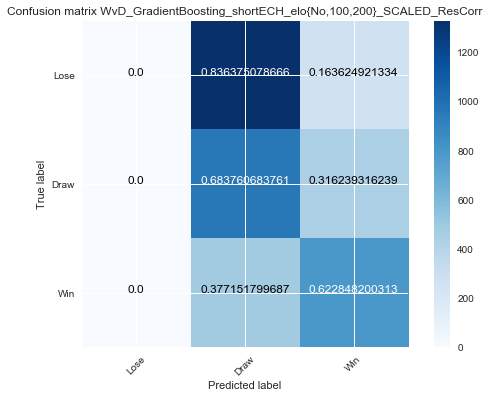

41.49
Normalized confusion matrix
[[ 0.          0.86658276  0.13341724]
 [ 0.          0.78561254  0.21438746]
 [ 0.          0.47652582  0.52347418]]


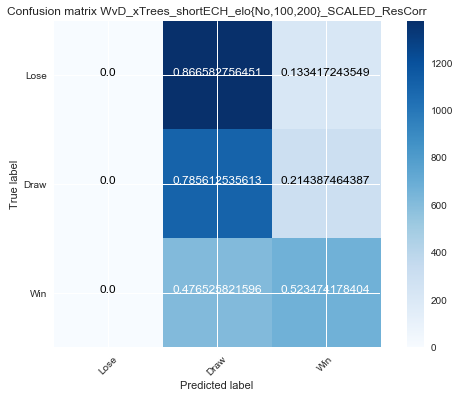

43.97
Normalized confusion matrix
[[ 0.          0.8250472   0.1749528 ]
 [ 0.          0.76424501  0.23575499]
 [ 0.          0.37010955  0.62989045]]


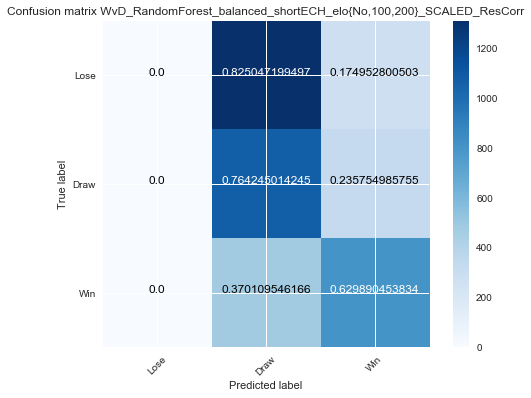

40.32
Normalized confusion matrix
[[ 0.          0.86721208  0.13278792]
 [ 0.          0.72863248  0.27136752]
 [ 0.          0.45305164  0.54694836]]


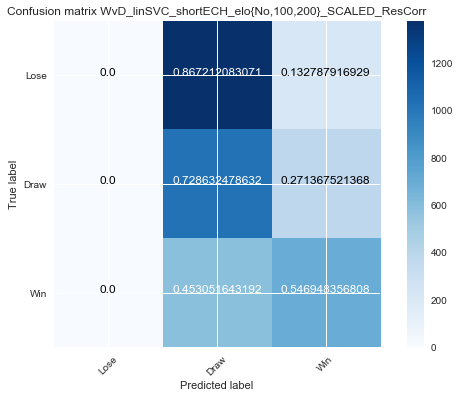

40.6
Normalized confusion matrix
[[ 0.          0.86784141  0.13215859]
 [ 0.          0.73005698  0.26994302]
 [ 0.          0.44522692  0.55477308]]


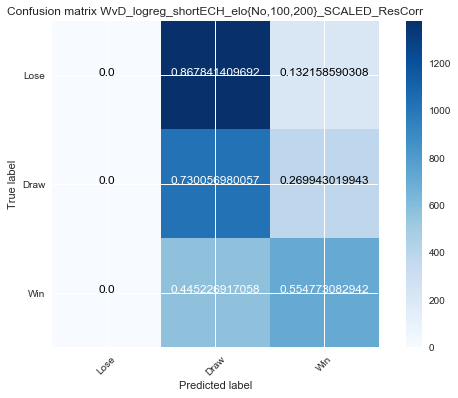

45.61
Normalized confusion matrix
[[ 0.7753304   0.          0.2246696 ]
 [ 0.58689459  0.          0.41310541]
 [ 0.43974961  0.          0.56025039]]


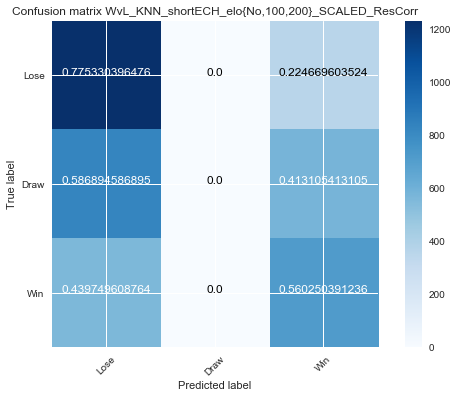

51.14
Normalized confusion matrix
[[ 0.79295154  0.          0.20704846]
 [ 0.5548433   0.          0.4451567 ]
 [ 0.27699531  0.          0.72300469]]


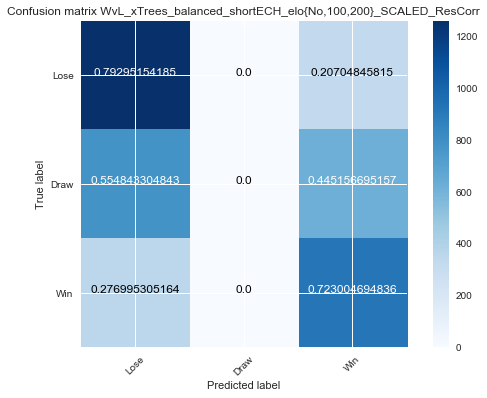

51.65
Normalized confusion matrix
[[ 0.83071114  0.          0.16928886]
 [ 0.59900285  0.          0.40099715]
 [ 0.30672926  0.          0.69327074]]


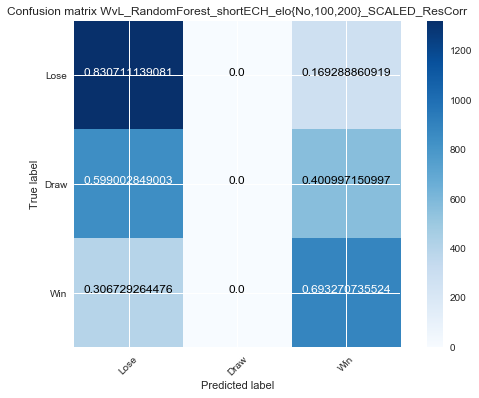

50.13
Normalized confusion matrix
[[ 0.75959723  0.          0.24040277]
 [ 0.53703704  0.          0.46296296]
 [ 0.26917058  0.          0.73082942]]


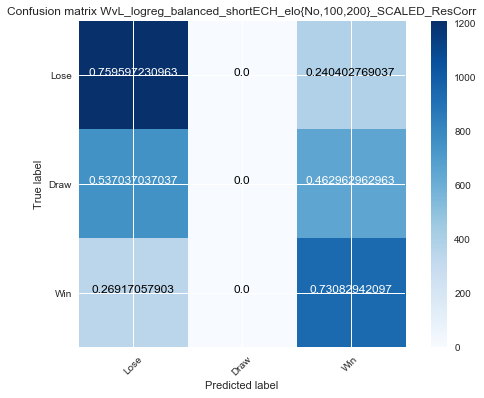

49.68
Normalized confusion matrix
[[ 0.80553807  0.          0.19446193]
 [ 0.61182336  0.          0.38817664]
 [ 0.34115806  0.          0.65884194]]


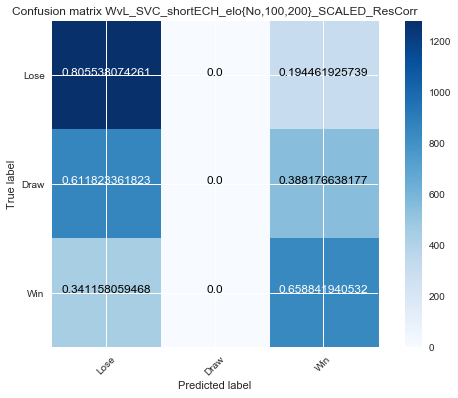

47.25
Normalized confusion matrix
[[ 0.79106356  0.          0.20893644]
 [ 0.63461538  0.          0.36538462]
 [ 0.40453834  0.          0.59546166]]


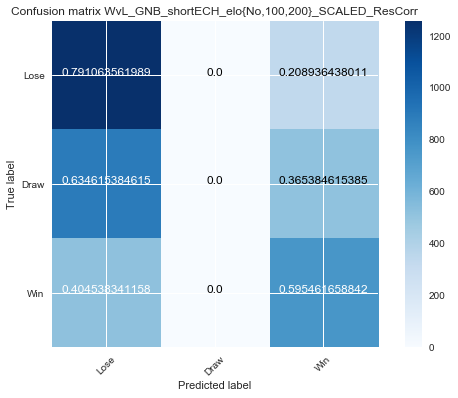

45.45
Normalized confusion matrix
[[ 0.7589679   0.          0.2410321 ]
 [ 0.61823362  0.          0.38176638]
 [ 0.42488263  0.          0.57511737]]


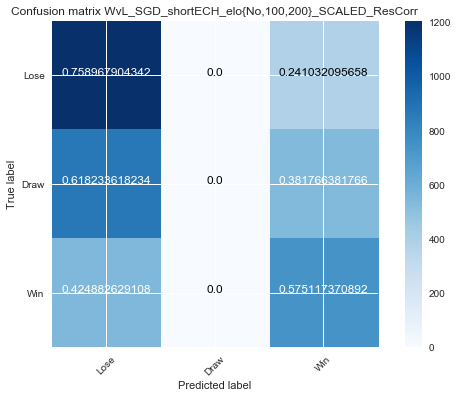

51.11
Normalized confusion matrix
[[ 0.80868471  0.          0.19131529]
 [ 0.58048433  0.          0.41951567]
 [ 0.29733959  0.          0.70266041]]


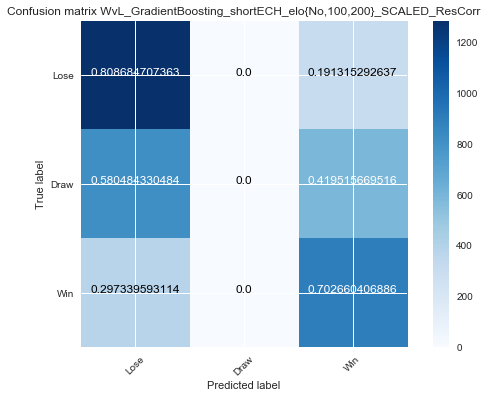

50.5
Normalized confusion matrix
[[ 0.82882316  0.          0.17117684]
 [ 0.62037037  0.          0.37962963]
 [ 0.342723    0.          0.657277  ]]


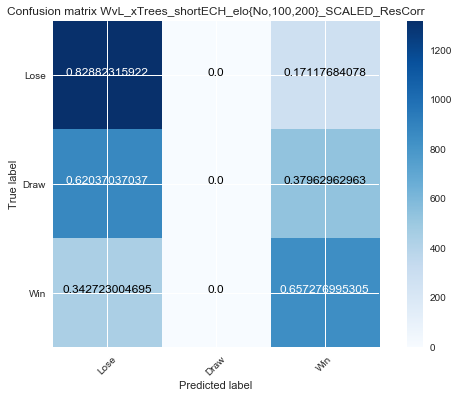

52.1
Normalized confusion matrix
[[ 0.81497797  0.          0.18502203]
 [ 0.55626781  0.          0.44373219]
 [ 0.27230047  0.          0.72769953]]


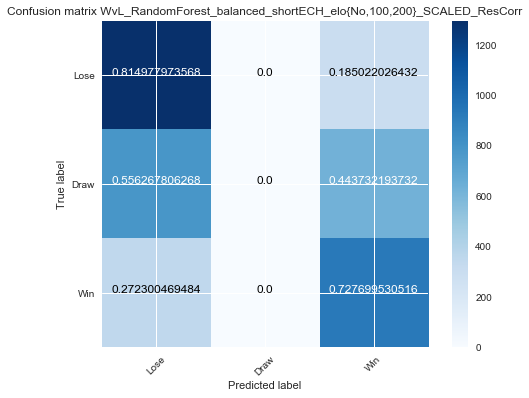

49.36
Normalized confusion matrix
[[ 0.8061674   0.          0.1938326 ]
 [ 0.63105413  0.          0.36894587]
 [ 0.35289515  0.          0.64710485]]


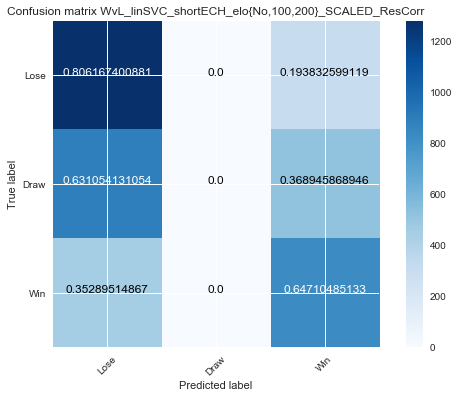

49.8
Normalized confusion matrix
[[ 0.80427942  0.          0.19572058]
 [ 0.62037037  0.          0.37962963]
 [ 0.33568075  0.          0.66431925]]


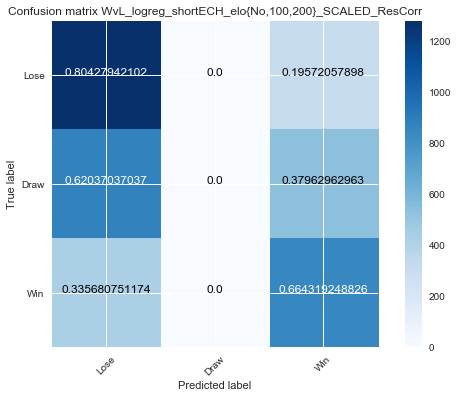

43.92
Normalized confusion matrix
[[ 0.6595343   0.3404657   0.        ]
 [ 0.41025641  0.58974359  0.        ]
 [ 0.39671362  0.60328638  0.        ]]


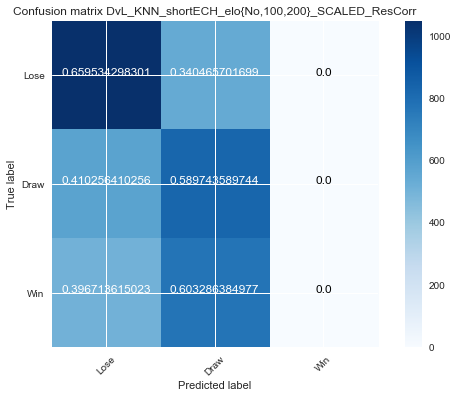

48.61
Normalized confusion matrix
[[ 0.68281938  0.31718062  0.        ]
 [ 0.29415954  0.70584046  0.        ]
 [ 0.1713615   0.8286385   0.        ]]


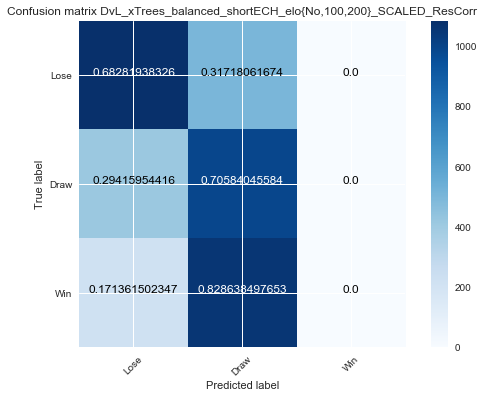

50.41
Normalized confusion matrix
[[ 0.75393329  0.24606671  0.        ]
 [ 0.31980057  0.68019943  0.        ]
 [ 0.19248826  0.80751174  0.        ]]


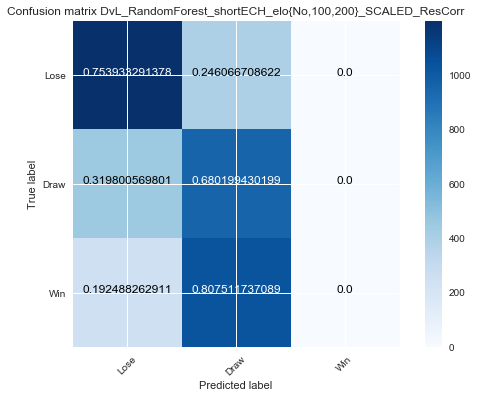

44.32
Normalized confusion matrix
[[ 0.63310258  0.36689742  0.        ]
 [ 0.36823362  0.63176638  0.        ]
 [ 0.15258216  0.84741784  0.        ]]


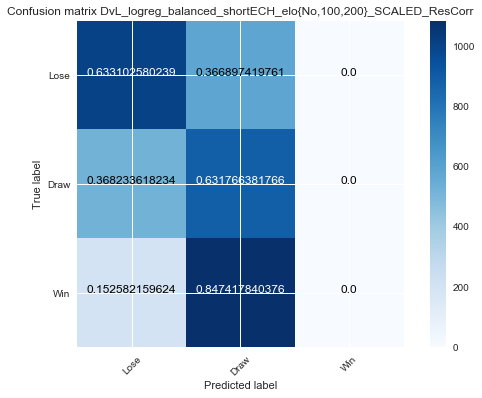

44.49
Normalized confusion matrix
[[ 0.66960352  0.33039648  0.        ]
 [ 0.4045584   0.5954416   0.        ]
 [ 0.20970266  0.79029734  0.        ]]


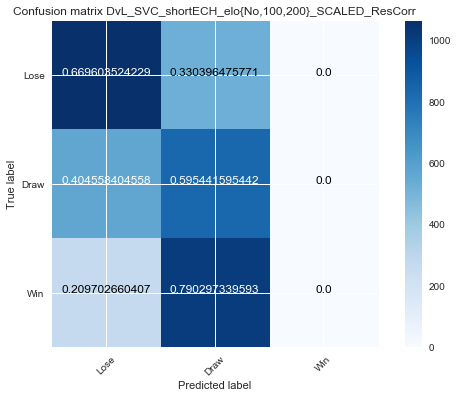

41.79
Normalized confusion matrix
[[ 0.57709251  0.42290749  0.        ]
 [ 0.38176638  0.61823362  0.        ]
 [ 0.20187793  0.79812207  0.        ]]


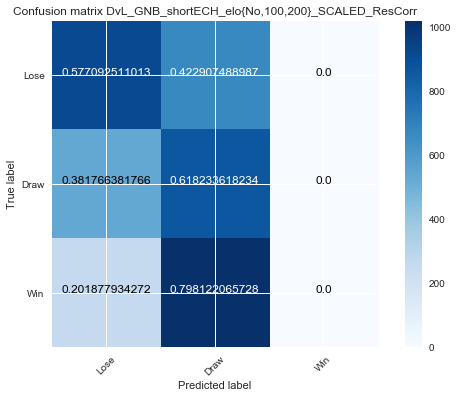

37.06
Normalized confusion matrix
[[ 0.3310258   0.6689742   0.        ]
 [ 0.247151    0.752849    0.        ]
 [ 0.22456964  0.77543036  0.        ]]


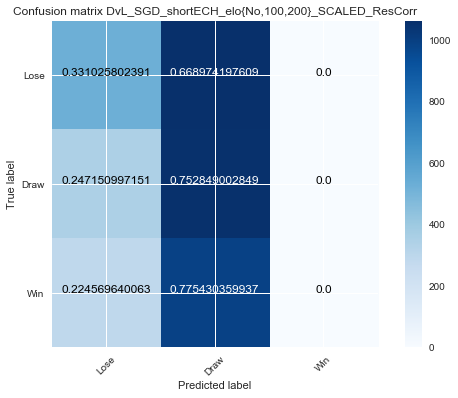

45.07
Normalized confusion matrix
[[ 0.69288861  0.30711139  0.        ]
 [ 0.41310541  0.58689459  0.        ]
 [ 0.20031299  0.79968701  0.        ]]


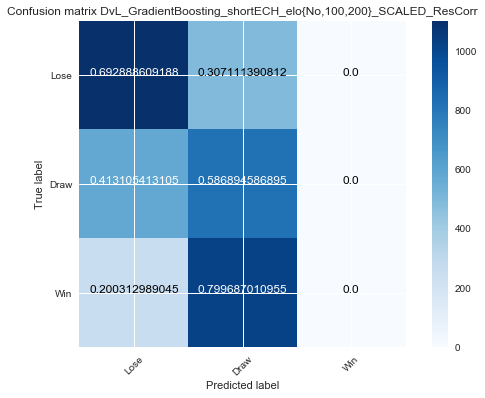

48.93
Normalized confusion matrix
[[ 0.72938955  0.27061045  0.        ]
 [ 0.33689459  0.66310541  0.        ]
 [ 0.20970266  0.79029734  0.        ]]


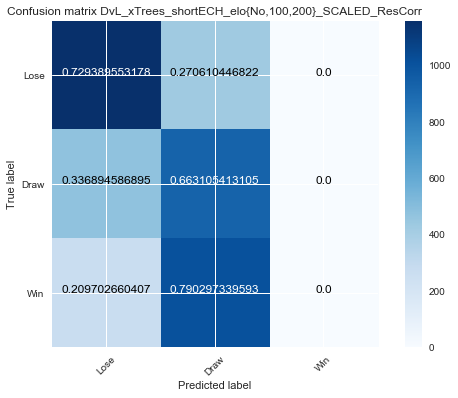

50.27
Normalized confusion matrix
[[ 0.72309629  0.27690371  0.        ]
 [ 0.28917379  0.71082621  0.        ]
 [ 0.18153365  0.81846635  0.        ]]


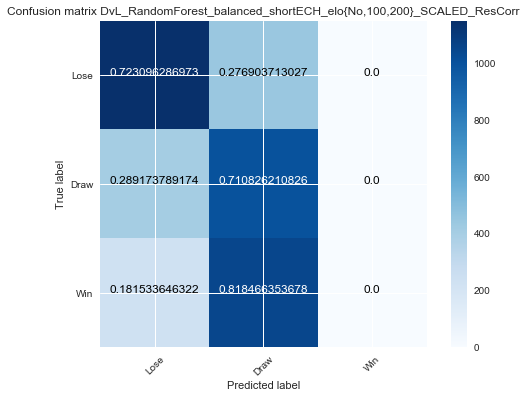

43.6
Normalized confusion matrix
[[ 0.68030208  0.31969792  0.        ]
 [ 0.44373219  0.55626781  0.        ]
 [ 0.19796557  0.80203443  0.        ]]


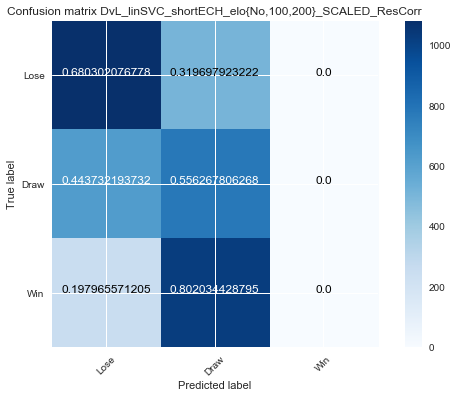

43.67
Normalized confusion matrix
[[ 0.67526746  0.32473254  0.        ]
 [ 0.43589744  0.56410256  0.        ]
 [ 0.19561815  0.80438185  0.        ]]


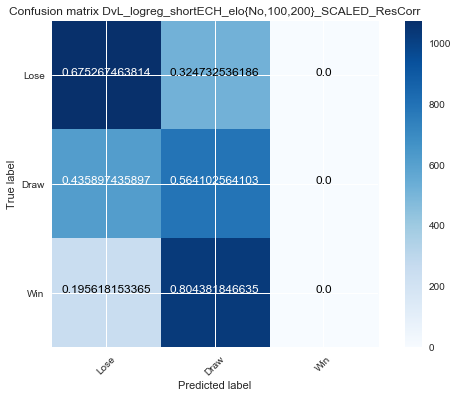

In [191]:
outputs = []
valid_pred_bl = []
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
for _data_name, data in _data.items():
    for model, prefix in models.items():
        name=_data_name+prefix+suffix
        #DATA
        train, test, target_train, target_test = data
        X=train
        Y=target_train
        #FIT
        model.fit(X, Y)
        #VALIDATE
        test = pd.concat([_data['WvD_'][1], _data['WvL_'][1], _data['DvL_'][1]])
        target_test = pd.concat([_data['WvD_'][3], _data['WvL_'][3], _data['DvL_'][3]])
        predictions = model.predict(test)
        validset_acc = round(accuracy_score(target_test, predictions) * 100, 2)
        
        #TESTFORLATER
        valid_pred = model.predict(validX)
        valid_pred_bl.append((name, valid_pred))
        
        print(validset_acc)
        #CONF MATRIX
        conf_matrix = confusion_matrix(target_test, predictions)
        classes=['Lose', 'Draw', 'Win']
        plot_confusion_matrix(conf_matrix, classes=classes,
                              normalize=True, title = 'Confusion matrix '+name, cmap=plt.cm.Blues)
        outputs.append((name, model, predictions))

outputs.sort(key=lambda x: x[0])

In [192]:
P = np.zeros((target_test.shape[0], len(outputs)))
base_learners = [(e[0],e[1]) for e in outputs]
P = pd.DataFrame(P, columns=[e for e, _ in base_learners])

for est_name, est, pred in outputs:
    P.loc[:, est_name] = pred

In [183]:
#metric
from sklearn.metrics import f1_score

# Data viz
from mlens.visualization import corr_X_y, corrmat

# Model evaluation
from mlens.metrics import make_scorer
from mlens.model_selection import Evaluator
from mlens.preprocessing import EnsembleTransformer

# Ensemble
from mlens.ensemble import SuperLearner

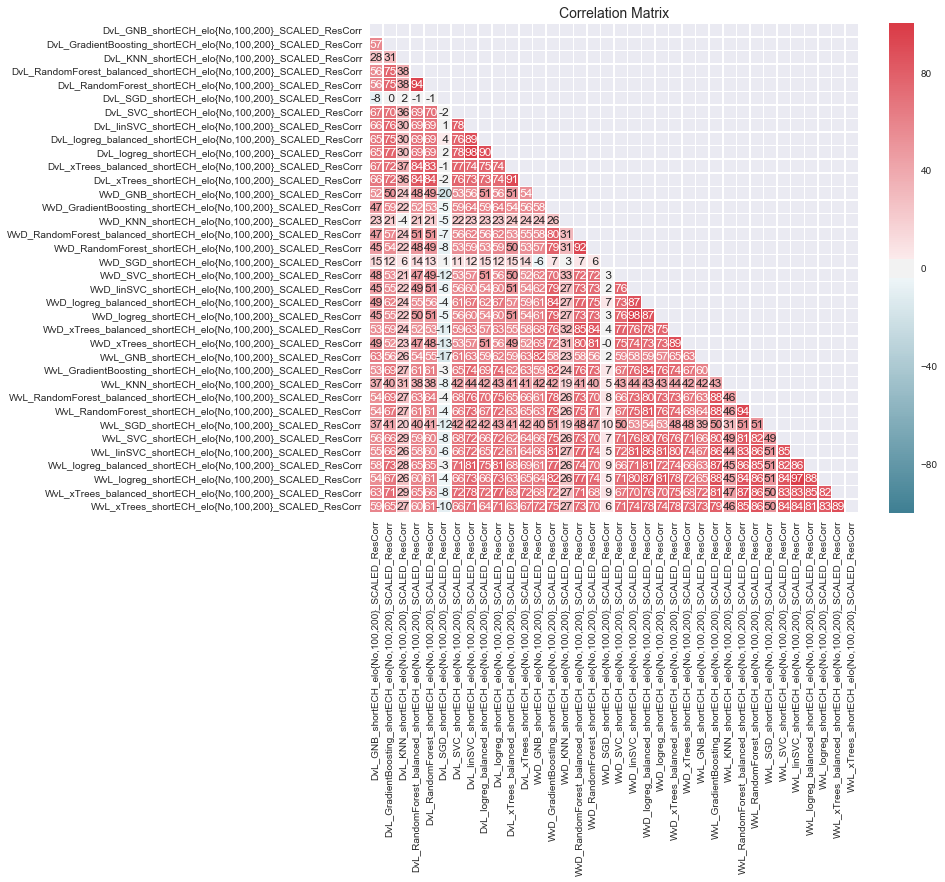

In [184]:
ax=corrmat(P.corr())

In [193]:
P['RESULT'] = target_test.to_frame().reset_index()['RESULT']

In [186]:
P.head()

,"DvL_GNB_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_GradientBoosting_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_KNN_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_RandomForest_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_RandomForest_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_SGD_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_SVC_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_linSVC_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_logreg_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_logreg_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_xTrees_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_xTrees_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_GNB_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_GradientBoosting_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_KNN_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_RandomForest_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_RandomForest_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_SGD_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_SVC_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_linSVC_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_logreg_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_logreg_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_xTrees_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_xTrees_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_GNB_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_GradientBoosting_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_KNN_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_RandomForest_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_RandomForest_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_SGD_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_SVC_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_linSVC_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_logreg_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_logreg_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_xTrees_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_xTrees_shortECH_elo{No,100,200}_SCALED_ResCorr",RESULT
0,-1,-1,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,0,0,1,0,0,1,0,0,0,0,0,0,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
1,0,0,0,0,0,-1,0,0,0,0,0,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,0,1,0,0,0,0,0,0,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,-1,1,1,1,1,1,1,1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,1,0,0,1,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1


In [187]:
valid = scaled_features_df.sample(frac=0.25, random_state=1)
validX = valid.drop('RESULT', axis=1)
validY = valid['RESULT']

train = scaled_features_df[~scaled_features_df.isin(valid.to_dict('l')).all(1)]
trainX = train.drop('RESULT', axis=1)
trainY = train['RESULT']

In [ ]:
#predict_valid with base learners
#outputs=[(name, model, predictions), ..., (name, model, predictions)]
    predictions = model.predict(validX)
    validset_acc = round(accuracy_score(validY, predictions) * 100, 2)
    print(name, validset_acc)
    valid_pred_bl.append((name, predictions))

In [194]:
valid_pred_bl.sort(key=lambda x: x[0])
P_validate = np.zeros((validX.shape[0], len(valid_pred_bl)))
P_validate = pd.DataFrame(P_validate, columns=[name for name, _ in valid_pred_bl])
for est_name, pred in valid_pred_bl:
    P_validate.loc[:, est_name] = pred

P_validate['RESULT'] = validY.to_frame().reset_index()['RESULT']

In [195]:
P_validate.describe()

,"DvL_GNB_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_GradientBoosting_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_KNN_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_RandomForest_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_RandomForest_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_SGD_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_SVC_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_linSVC_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_logreg_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_logreg_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_xTrees_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","DvL_xTrees_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_GNB_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_GradientBoosting_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_KNN_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_RandomForest_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_RandomForest_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_SGD_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_SVC_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_linSVC_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_logreg_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_logreg_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_xTrees_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","WvD_xTrees_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_GNB_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_GradientBoosting_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_KNN_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_RandomForest_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_RandomForest_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_SGD_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_SVC_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_linSVC_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_logreg_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_logreg_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_xTrees_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr","WvL_xTrees_shortECH_elo{No,100,200}_SCALED_ResCorr",RESULT
count,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000,3464.000000
mean,-0.363453,-0.392610,-0.456120,-0.361432,-0.382217,-0.259527,-0.410219,-0.406755,-0.350462,-0.406467,-0.358256,-0.401559,0.320439,0.405312,0.423210,0.410797,0.380196,0.477483,0.341513,0.338626,0.409931,0.340935,0.396940,0.336894,-0.175520,-0.046767,-0.095843,-0.001155,-0.066397,-0.155312,-0.113741,-0.139723,0.030023,-0.116051,-0.000577,-0.127021,0.178118
std,0.481063,0.488402,0.498143,0.480485,0.485999,0.438438,0.491944,0.491299,0.477183,0.491244,0.479557,0.490284,0.466713,0.491023,0.494139,0.492049,0.485505,0.499565,0.474285,0.473311,0.491892,0.474092,0.489334,0.472716,0.984618,0.999050,0.995540,1.000144,0.997937,0.988008,0.993654,0.990334,0.999694,0.993387,1.000144,0.992043,0.841650
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [196]:
rf = RandomForestClassifier(n_estimators=800, criterion='gini', max_depth=15, min_samples_split=20, 
                                        min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', 
                                        max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False,
                                        n_jobs=-1, random_state=None, verbose=0, warm_start=False, class_weight=None)
X=P.drop('RESULT', axis=1)
Y=P['RESULT']
#FIT
rf.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=800, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

56.35
Normalized confusion matrix
[[ 0.67728674  0.21068859  0.11202467]
 [ 0.33740289  0.39622642  0.2663707 ]
 [ 0.21509434  0.19622642  0.58867925]]


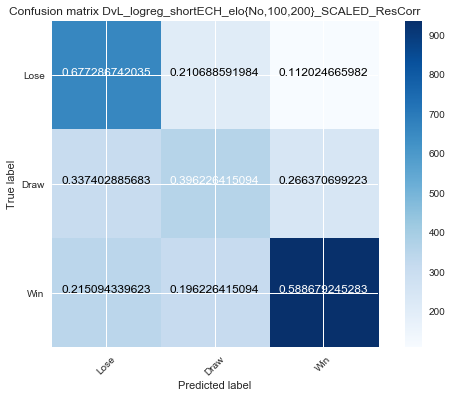

In [197]:
testX=P_validate.drop('RESULT', axis=1)
testY=P_validate['RESULT']
predictions = rf.predict(testX)
validset_acc = round(accuracy_score(testY, predictions) * 100, 2)
print(validset_acc)
#CONF MATRIX
conf_matrix = confusion_matrix(testY, predictions)
classes=['Lose', 'Draw', 'Win']
plot_confusion_matrix(conf_matrix, classes=classes,
                      normalize=True, title = 'Confusion matrix '+name, cmap=plt.cm.Blues)


In [99]:
from mlens.ensemble import SequentialEnsemble
ensemble = SequentialEnsemble()

In [119]:
ensemble.add('blend', base_learners)

SequentialEnsemble(array_check=2, backend='multiprocessing',
          layers=LayerContainer(backend='multiprocessing',
        layers=OrderedDict([('layer-1', Layer(cls='blend', cls_kwargs=None,
   estimators=[('DvL_GNB_shortECH_elo{No,100,200}_SCALED_ResCorr', GaussianNB(priors=None)), ('DvL_GradientBoosting_shortECH_elo{No,100,200}_SCALED_ResCorr', GradientBoostingC...ion=True, scorer=None, verbose=False))]),
        n_jobs=-1, raise_on_exception=True, verbose=False),
          n_jobs=-1, raise_on_exception=True, random_state=None,
          scorer=None, shuffle=False, verbose=False)

In [120]:
intermediate_learners = [(modelRndForest, "RandomForest"),
          (modelXTree, 'xTrees'),
          (modelRndForest_balanced, "RandomForest_balanced"),
          (modelXTree_balanced, 'xTrees_balanced')]
intermediate_learners = [(y,x) for (x,y) in intermediate_learners]
ensemble.add('stack', intermediate_learners)

SequentialEnsemble(array_check=2, backend='multiprocessing',
          layers=LayerContainer(backend='multiprocessing',
        layers=OrderedDict([('layer-1', Layer(cls='blend', cls_kwargs=None,
   estimators=[('DvL_GNB_shortECH_elo{No,100,200}_SCALED_ResCorr', GaussianNB(priors=None)), ('DvL_GradientBoosting_shortECH_elo{No,100,200}_SCALED_ResCorr', GradientBoostingC...ion=True, scorer=None, verbose=False))]),
        n_jobs=-1, raise_on_exception=True, verbose=False),
          n_jobs=-1, raise_on_exception=True, random_state=None,
          scorer=None, shuffle=False, verbose=False)

In [121]:
from sklearn.linear_model import Lasso
ensemble.add_meta(LogisticRegression(n_jobs = -1, class_weight=None))

SequentialEnsemble(array_check=2, backend='multiprocessing',
          layers=LayerContainer(backend='multiprocessing',
        layers=OrderedDict([('layer-1', Layer(cls='blend', cls_kwargs=None,
   estimators=[('DvL_GNB_shortECH_elo{No,100,200}_SCALED_ResCorr', GaussianNB(priors=None)), ('DvL_GradientBoosting_shortECH_elo{No,100,200}_SCALED_ResCorr', GradientBoostingC...ion=True, scorer=None, verbose=False))]),
        n_jobs=-1, raise_on_exception=True, verbose=False),
          n_jobs=-1, raise_on_exception=True, random_state=None,
          scorer=None, shuffle=False, verbose=False)

In [123]:
name='myFirstEnsembleStack'
#FIT
ensemble.fit(trainX, trainY)
#VALIDATE
predictions = model.predict(validX)
validset_acc = round(accuracy_score(validY, predictions) * 100, 2)
print(validset_acc)
#CONF MATRIX
conf_matrix = confusion_matrix(validY, predictions)
classes=['Lose', 'Draw', 'Win']
plot_confusion_matrix(conf_matrix, classes=classes,
                      normalize=True, title = 'Confusion matrix '+name, cmap=plt.cm.Blues)

JoblibAttributeError: JoblibAttributeError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...flow\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py in _run_code(code=<code object <module> at 0x000001FA07447F60, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\ernest.chocholowski\AppData\Local\Conti...ges\__pycache__\ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\ernest.chocholowski\AppData\Local\Conti...ensorflow\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...flow\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\e...ow\\lib\\site-packages\\ipykernel\\kernelapp.py'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...flow\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x000001FA07447F60, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': r'C:\Users\ernest.chocholowski\AppData\Local\Conti...ges\__pycache__\ipykernel_launcher.cpython-35.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'C:\Users\ernest.chocholowski\AppData\Local\Conti...ensorflow\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...flow\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'C:\\Users\\e...ow\\lib\\site-packages\\ipykernel\\kernelapp.py'>, 'sys': <module 'sys' (built-in)>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()
     17 
     18 
     19 
     20 

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tornado\ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "name='myFirstEnsembleStack'\n#FIT\nensemble.fit(tr...le = 'Confusion matrix '+name, cmap=plt.cm.Blues)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 6, 19, 9, 40, 45, 594708, tzinfo=datetime.timezone.utc), 'msg_id': 'B35BF61F0FC7495E81324089522085DE', 'msg_type': 'execute_request', 'session': '22FA7B0EA7F24B29818F71DDB9C1C26E', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'B35BF61F0FC7495E81324089522085DE', 'msg_type': 'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'22FA7B0EA7F24B29818F71DDB9C1C26E']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "name='myFirstEnsembleStack'\n#FIT\nensemble.fit(tr...le = 'Confusion matrix '+name, cmap=plt.cm.Blues)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 6, 19, 9, 40, 45, 594708, tzinfo=datetime.timezone.utc), 'msg_id': 'B35BF61F0FC7495E81324089522085DE', 'msg_type': 'execute_request', 'session': '22FA7B0EA7F24B29818F71DDB9C1C26E', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'B35BF61F0FC7495E81324089522085DE', 'msg_type': 'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'22FA7B0EA7F24B29818F71DDB9C1C26E'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "name='myFirstEnsembleStack'\n#FIT\nensemble.fit(tr...le = 'Confusion matrix '+name, cmap=plt.cm.Blues)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2017, 6, 19, 9, 40, 45, 594708, tzinfo=datetime.timezone.utc), 'msg_id': 'B35BF61F0FC7495E81324089522085DE', 'msg_type': 'execute_request', 'session': '22FA7B0EA7F24B29818F71DDB9C1C26E', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'B35BF61F0FC7495E81324089522085DE', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="name='myFirstEnsembleStack'\n#FIT\nensemble.fit(tr...le = 'Confusion matrix '+name, cmap=plt.cm.Blues)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "name='myFirstEnsembleStack'\n#FIT\nensemble.fit(tr...le = 'Confusion matrix '+name, cmap=plt.cm.Blues)"
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("name='myFirstEnsembleStack'\n#FIT\nensemble.fit(tr...le = 'Confusion matrix '+name, cmap=plt.cm.Blues)",), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("name='myFirstEnsembleStack'\n#FIT\nensemble.fit(tr...le = 'Confusion matrix '+name, cmap=plt.cm.Blues)",)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="name='myFirstEnsembleStack'\n#FIT\nensemble.fit(tr...le = 'Confusion matrix '+name, cmap=plt.cm.Blues)", store_history=True, silent=False, shell_futures=True)
   2678                 self.displayhook.exec_result = result
   2679 
   2680                 # Execute the user code
   2681                 interactivity = "none" if silent else self.ast_node_interactivity
   2682                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2683                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2684                 
   2685                 self.last_execution_succeeded = not has_raised
   2686 
   2687                 # Reset this so later displayed values do not modify the

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-123-5c7ef2fc3ee9>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 1fa487693c8, executio..._before_exec=None error_in_exec=None result=None>)
   2782 
   2783         try:
   2784             for i, node in enumerate(to_run_exec):
   2785                 mod = ast.Module([node])
   2786                 code = compiler(mod, cell_name, "exec")
-> 2787                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x000001FA44EFD780, file "<ipython-input-123-5c7ef2fc3ee9>", line 3>
        result = <ExecutionResult object at 1fa487693c8, executio..._before_exec=None error_in_exec=None result=None>
   2788                     return True
   2789 
   2790             for i, node in enumerate(to_run_interactive):
   2791                 mod = ast.Interactive([node])

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x000001FA44EFD780, file "<ipython-input-123-5c7ef2fc3ee9>", line 3>, result=<ExecutionResult object at 1fa487693c8, executio..._before_exec=None error_in_exec=None result=None>)
   2842         outflag = True  # happens in more places, so it's easier as default
   2843         try:
   2844             try:
   2845                 self.hooks.pre_run_code_hook()
   2846                 #rprint('Running code', repr(code_obj)) # dbg
-> 2847                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x000001FA44EFD780, file "<ipython-input-123-5c7ef2fc3ee9>", line 3>
        self.user_global_ns = {'DRAW':        home_player_1_overall_rating  away_player...
12592  1.174520    -0.002704 -0.544673       0  , 'DRAWvsLOSE':        home_player_1_overall_rating  away_player...
14518  1.281230     0.783397 -2.543106      -1  , 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'EnsembleTransformer': <class 'mlens.preprocessing.ensemble_transformer.EnsembleTransformer'>, 'Evaluator': <class 'mlens.model_selection.model_selection.Evaluator'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', '# SQL\nimport sqlite3\n# Data Manipulation\nimport ...matches_df[NoScalling]\n\nscaled_features_df.head()', "WIN = scaled_features_df[scaled_features_df['RES...d_features_df[scaled_features_df['RESULT'] == -1]", 'print("WIN_LEN:",len(WIN))\nprint("DRAW_LEN:",len(DRAW))\nprint("LOSE_LEN:",len(LOSE))', 'print("WIN_LEN:",len(WIN//2))\nprint("DRAW_LEN:",len(DRAW))\nprint("LOSE_LEN:",len(LOSE))', 'print("WIN_LEN:",len(WIN//2))\nprint("DRAW_LEN:",len(DRAW))\nprint("LOSE_LEN:",len(LOSE))', 'print("WIN_LEN:",len(WIN)//2)\nprint("DRAW_LEN:",len(DRAW))\nprint("LOSE_LEN:",len(LOSE))', 'msk = np.random.rand(len(df)) < 0.5', 'msk = np.random.rand(len(WIN)) < 0.5', 'len(msk)', 'print("WIN_LEN:",len(WIN))\nprint("DRAW_LEN:",len(DRAW))\nprint("LOSE_LEN:",len(LOSE))', '#gets a random 80% of the entire set\nWIN_one = W...the dataset\nWIN_two = WIN.loc[~WIN.isin(WIN_one)]', '#gets a random 80% of the entire set\nWIN_one = W...ortion of the dataset\nWIN_two = WIN.loc[~WIN_one]', 'WIN.head()', 'WIN.RESULT.describe()', 'WIN.head()', "WIN_one.to_dict('l')", "WIN_one.to_dict('l')\nWIN.isin(WIN_one.to_dict('l'))", '# SQL\nimport sqlite3\n# Data Manipulation\nimport ...matches_df[NoScalling]\n\nscaled_features_df.head()', "WIN_one.to_dict('l')", ...], ...}
        self.user_ns = {'DRAW':        home_player_1_overall_rating  away_player...
12592  1.174520    -0.002704 -0.544673       0  , 'DRAWvsLOSE':        home_player_1_overall_rating  away_player...
14518  1.281230     0.783397 -2.543106      -1  , 'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'EnsembleTransformer': <class 'mlens.preprocessing.ensemble_transformer.EnsembleTransformer'>, 'Evaluator': <class 'mlens.model_selection.model_selection.Evaluator'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, 'GradientBoostingClassifier': <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>, 'Imputer': <class 'sklearn.preprocessing.imputation.Imputer'>, 'In': ['', '# SQL\nimport sqlite3\n# Data Manipulation\nimport ...matches_df[NoScalling]\n\nscaled_features_df.head()', "WIN = scaled_features_df[scaled_features_df['RES...d_features_df[scaled_features_df['RESULT'] == -1]", 'print("WIN_LEN:",len(WIN))\nprint("DRAW_LEN:",len(DRAW))\nprint("LOSE_LEN:",len(LOSE))', 'print("WIN_LEN:",len(WIN//2))\nprint("DRAW_LEN:",len(DRAW))\nprint("LOSE_LEN:",len(LOSE))', 'print("WIN_LEN:",len(WIN//2))\nprint("DRAW_LEN:",len(DRAW))\nprint("LOSE_LEN:",len(LOSE))', 'print("WIN_LEN:",len(WIN)//2)\nprint("DRAW_LEN:",len(DRAW))\nprint("LOSE_LEN:",len(LOSE))', 'msk = np.random.rand(len(df)) < 0.5', 'msk = np.random.rand(len(WIN)) < 0.5', 'len(msk)', 'print("WIN_LEN:",len(WIN))\nprint("DRAW_LEN:",len(DRAW))\nprint("LOSE_LEN:",len(LOSE))', '#gets a random 80% of the entire set\nWIN_one = W...the dataset\nWIN_two = WIN.loc[~WIN.isin(WIN_one)]', '#gets a random 80% of the entire set\nWIN_one = W...ortion of the dataset\nWIN_two = WIN.loc[~WIN_one]', 'WIN.head()', 'WIN.RESULT.describe()', 'WIN.head()', "WIN_one.to_dict('l')", "WIN_one.to_dict('l')\nWIN.isin(WIN_one.to_dict('l'))", '# SQL\nimport sqlite3\n# Data Manipulation\nimport ...matches_df[NoScalling]\n\nscaled_features_df.head()', "WIN_one.to_dict('l')", ...], ...}
   2848             finally:
   2849                 # Reset our crash handler in place
   2850                 sys.excepthook = old_excepthook
   2851         except SystemExit as e:

...........................................................................
C:\Users\ernest.chocholowski\Desktop\GIT\SoccerAnalysis\<ipython-input-123-5c7ef2fc3ee9> in <module>()
      1 
      2 
----> 3 
      4 name='myFirstEnsembleStack'
      5 #FIT
      6 ensemble.fit(trainX, trainY)
      7 #VALIDATE
      8 predictions = model.predict(validX)
      9 validset_acc = round(accuracy_score(validY, predictions) * 100, 2)
     10 print(validset_acc)
     11 #CONF MATRIX
     12 conf_matrix = confusion_matrix(validY, predictions)
     13 classes=['Lose', 'Draw', 'Win']

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\mlens\ensemble\base.py in fit(self=SequentialEnsemble(array_check=2, backend='multi...       scorer=None, shuffle=False, verbose=False), X=array([[-0.04586072,  0.22469482, -1.22123789, ....  1.3245056 ,
         1.30746492, -2.9315475 ]]), y=array([ 1, -1, -1, ..., -1,  1,  1], dtype=int64))
    711         if self.shuffle:
    712             r = check_random_state(self.random_state)
    713             idx = r.permutation(X.shape[0])
    714             X, y = X[idx], y[idx]
    715 
--> 716         self.scores_ = self.layers.fit(X, y)
        self.scores_ = None
        self.layers.fit = <bound method LayerContainer.fit of LayerContain...jobs=-1, raise_on_exception=True, verbose=False)>
        X = array([[-0.04586072,  0.22469482, -1.22123789, ....  1.3245056 ,
         1.30746492, -2.9315475 ]])
        y = array([ 1, -1, -1, ..., -1,  1,  1], dtype=int64)
    717 
    718         return self
    719 
    720     def predict(self, X):

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\mlens\ensemble\base.py in fit(self=LayerContainer(backend='multiprocessing',
      ..._jobs=-1, raise_on_exception=True, verbose=False), X=array([[-0.04586072,  0.22469482, -1.22123789, ....  1.3245056 ,
         1.30746492, -2.9315475 ]]), y=array([ 1, -1, -1, ..., -1,  1,  1], dtype=int64), return_preds=None, **process_kwargs={})
    229         processor = ParallelProcessing(self)
    230         processor.initialize('fit', X, y, **process_kwargs)
    231 
    232         # Fit ensemble
    233         try:
--> 234             processor.process()
        processor.process = <bound method ParallelProcessing.process of <mlens.parallel.manager.ParallelProcessing object>>
    235 
    236             if self.verbose:
    237                 print_time(t0, "Fit complete", file=pout, flush=True)
    238 

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\mlens\parallel\manager.py in process(self=<mlens.parallel.manager.ParallelProcessing object>)
    213                       mmap_mode='w+',
    214                       verbose=self.layers.verbose,
    215                       backend=self.layers.backend) as parallel:
    216 
    217             for n, lyr in enumerate(self.layers.layers.values()):
--> 218                 self._partial_process(n, lyr, parallel)
        self._partial_process = <bound method ParallelProcessing._partial_proces...lens.parallel.manager.ParallelProcessing object>>
        n = 3
        lyr = Layer(cls='blend', cls_kwargs=None,
   estimator...se_on_exception=True, scorer=None, verbose=False)
        parallel = Parallel(n_jobs=-1)
    219 
    220         self.__fitted__ = 1
    221 
    222     def get_preds(self, n=-1, dtype=np.float, order='C'):

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\mlens\parallel\manager.py in _partial_process(self=<mlens.parallel.manager.ParallelProcessing object>, n=3, lyr=Layer(cls='blend', cls_kwargs=None,
   estimator...se_on_exception=True, scorer=None, verbose=False), parallel=Parallel(n_jobs=-1))
    303         if 'X' in fargs:
    304             kwargs['X'] = self.job.P[n]
    305         if 'P' in fargs:
    306             kwargs['P'] = self.job.P[n + 1]
    307 
--> 308         f(**kwargs)
        f = <bound method BaseEstimator.fit of <mlens.parallel.blend.Blender object>>
        kwargs = {'P': memmap([[ nan,  nan,  nan, ...,   0.,   0.,   0....      [ nan,  nan,  nan, ...,   0.,   0.,   0.]]), 'X': memmap([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]]), 'dir': r'C:\Users\ERNEST~1.CHO\AppData\Local\Temp\mlens_23m0k6kd', 'parallel': Parallel(n_jobs=-1), 'y': memmap([ 1, -1, -1, ..., -1,  1,  1], dtype=int64)}
    309 
    310 
    311 ###############################################################################
    312 class ParallelEvaluation(object):

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\mlens\parallel\estimation.py in fit(self=<mlens.parallel.blend.Blender object>, X=memmap([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]]), y=memmap([-1,  0,  0, ..., -1,  1,  1], dtype=int64), P=memmap([[ nan,  nan,  nan, ...,   0.,   0.,   0....      [ nan,  nan,  nan, ...,   0.,   0.,   0.]]), dir=r'C:\Users\ERNEST~1.CHO\AppData\Local\Temp\mlens_23m0k6kd', parallel=Parallel(n_jobs=-1))
    172                                       raise_on_exception=self.raise_,
    173                                       preprocess=preprocess,
    174                                       ivals=self.ivals,
    175                                       attr=pred_method,
    176                                       scorer=self.scorer)
--> 177                      for case, tri, tei, instance_list in self.e
        self.e = [(None, (0, 2598), (2598, 5195), [('DvL_GNB_shortECH_elo{No,100,200}_SCALED_ResCorr', GaussianNB(priors=None)), ('DvL_GradientBoosting_shortECH_elo{No,100,200}_SCALED_ResCorr', GradientBoostingClassifier(criterion='friedman_m...      subsample=1.0, verbose=0, warm_start=False)), ('DvL_KNN_shortECH_elo{No,100,200}_SCALED_ResCorr', KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=3, p=2,
           weights='uniform')), ('DvL_RandomForest_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr', RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False)), ('DvL_RandomForest_shortECH_elo{No,100,200}_SCALED_ResCorr', RandomForestClassifier(bootstrap=True, class_wei...  random_state=None, verbose=0, warm_start=False)), ('DvL_SGD_shortECH_elo{No,100,200}_SCALED_ResCorr', SGDClassifier(alpha=0.0001, average=False, class...shuffle=True,
       verbose=0, warm_start=False)), ('DvL_SVC_shortECH_elo{No,100,200}_SCALED_ResCorr', SVC(C=1.0, cache_size=200, class_weight=None, co...None, shrinking=True,
  tol=0.001, verbose=False)), ('DvL_linSVC_shortECH_elo{No,100,200}_SCALED_ResCorr', LinearSVC(C=1.0, class_weight=None, dual=True, f...', random_state=None, tol=0.0001,
     verbose=0)), ('DvL_logreg_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr', LogisticRegression(C=1.0, class_weight='balanced...linear', tol=0.0001, verbose=0, warm_start=False)), ('DvL_logreg_shortECH_elo{No,100,200}_SCALED_ResCorr', LogisticRegression(C=1.0, class_weight=None, dua...ol=0.0001,
          verbose=0, warm_start=False)), ('DvL_xTrees_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr', ExtraTreesClassifier(bootstrap=False, class_weig..., random_state=None, verbose=0, warm_start=False)), ('DvL_xTrees_shortECH_elo{No,100,200}_SCALED_ResCorr', ExtraTreesClassifier(bootstrap=False, class_weig...ate=None,
           verbose=0, warm_start=False)), ('WvD_GNB_shortECH_elo{No,100,200}_SCALED_ResCorr', GaussianNB(priors=None)), ('WvD_GradientBoosting_shortECH_elo{No,100,200}_SCALED_ResCorr', GradientBoostingClassifier(criterion='friedman_m...      subsample=1.0, verbose=0, warm_start=False)), ('WvD_KNN_shortECH_elo{No,100,200}_SCALED_ResCorr', KNeighborsClassifier(algorithm='auto', leaf_size...n_neighbors=3, p=2,
           weights='uniform')), ('WvD_RandomForest_balanced_shortECH_elo{No,100,200}_SCALED_ResCorr', RandomForestClassifier(bootstrap=True, class_wei...te=None, verbose=0,
            warm_start=False)), ('WvD_RandomForest_shortECH_elo{No,100,200}_SCALED_ResCorr', RandomForestClassifier(bootstrap=True, class_wei...  random_state=None, verbose=0, warm_start=False)), ('WvD_SGD_shortECH_elo{No,100,200}_SCALED_ResCorr', SGDClassifier(alpha=0.0001, average=False, class...shuffle=True,
       verbose=0, warm_start=False)), ('WvD_SVC_shortECH_elo{No,100,200}_SCALED_ResCorr', SVC(C=1.0, cache_size=200, class_weight=None, co...None, shrinking=True,
  tol=0.001, verbose=False)), ('WvD_linSVC_shortECH_elo{No,100,200}_SCALED_ResCorr', LinearSVC(C=1.0, class_weight=None, dual=True, f...', random_state=None, tol=0.0001,
     verbose=0)), ...])]
    178                      for inst_name, instance in instance_list)
    179 
    180         else:
    181             parallel(delayed(_fit)(dir=dir,

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\mlens\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object BaseEstimator.fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
AttributeError                                     Mon Jun 19 11:41:32 2017
PID: 5952Python 3.5.3: C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\python.exe
...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\mlens\externals\joblib\parallel.py in __call__(self=<mlens.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function fit_est>, (), {'attr': 'predict_proba', 'case': None, 'dir': r'C:\Users\ERNEST~1.CHO\AppData\Local\Temp\mlens_23m0k6kd', 'idx': ((0, 2598), (2598, 5195), 15), 'inst': SGDClassifier(alpha=0.0001, average=False, class...shuffle=True,
       verbose=0, warm_start=False), 'inst_name': 'DvL_SGD_shortECH_elo{No,100,200}_SCALED_ResCorr', 'ivals': (0.1, 600), 'name': 'layer-5', 'pred': memmap([[ nan,  nan,  nan, ...,   0.,   0.,   0....      [ nan,  nan,  nan, ...,   0.,   0.,   0.]]), 'preprocess': False, ...})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\mlens\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function fit_est>
        args = ()
        kwargs = {'attr': 'predict_proba', 'case': None, 'dir': r'C:\Users\ERNEST~1.CHO\AppData\Local\Temp\mlens_23m0k6kd', 'idx': ((0, 2598), (2598, 5195), 15), 'inst': SGDClassifier(alpha=0.0001, average=False, class...shuffle=True,
       verbose=0, warm_start=False), 'inst_name': 'DvL_SGD_shortECH_elo{No,100,200}_SCALED_ResCorr', 'ivals': (0.1, 600), 'name': 'layer-5', 'pred': memmap([[ nan,  nan,  nan, ...,   0.,   0.,   0....      [ nan,  nan,  nan, ...,   0.,   0.,   0.]]), 'preprocess': False, ...}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\mlens\parallel\estimation.py in fit_est(dir=r'C:\Users\ERNEST~1.CHO\AppData\Local\Temp\mlens_23m0k6kd', case=None, inst_name='DvL_SGD_shortECH_elo{No,100,200}_SCALED_ResCorr', inst=SGDClassifier(alpha=0.0001, average=False, class...shuffle=True,
       verbose=0, warm_start=False), x=memmap([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]]), y=memmap([-1,  0,  0, ..., -1,  1,  1], dtype=int64), pred=memmap([[ nan,  nan,  nan, ...,   0.,   0.,   0....      [ nan,  nan,  nan, ...,   0.,   0.,   0.]]), idx=((0, 2598), (2598, 5195), 15), raise_on_exception=True, preprocess=False, name='layer-5', ivals=(0.1, 600), attr='predict_proba', scorer=None)
    492         xtest, ytest = _slice_array(x, y, tei)
    493 
    494         for tr_name, tr in tr_list:
    495             xtest = tr.transform(xtest)
    496 
--> 497         p = getattr(inst, attr)(xtest)
        p = undefined
        inst = SGDClassifier(alpha=0.0001, average=False, class...shuffle=True,
       verbose=0, warm_start=False)
        attr = 'predict_proba'
        xtest = memmap([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])
    498 
    499         # Assign predictions to matrix
    500         _assign_predictions(pred, p, tei, col, n)
    501 

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py in predict_proba(self=SGDClassifier(alpha=0.0001, average=False, class...shuffle=True,
       verbose=0, warm_start=False))
    757 
    758         The justification for the formula in the loss="modified_huber"
    759         case is in the appendix B in:
    760         http://jmlr.csail.mit.edu/papers/volume2/zhang02c/zhang02c.pdf
    761         """
--> 762         self._check_proba()
        self._check_proba = <bound method SGDClassifier._check_proba of SGDC...huffle=True,
       verbose=0, warm_start=False)>
    763         return self._predict_proba
    764 
    765     def _predict_proba(self, X):
    766         if self.loss == "log":

...........................................................................
C:\Users\ernest.chocholowski\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\stochastic_gradient.py in _check_proba(self=SGDClassifier(alpha=0.0001, average=False, class...shuffle=True,
       verbose=0, warm_start=False))
    719     def _check_proba(self):
    720         check_is_fitted(self, "t_")
    721 
    722         if self.loss not in ("log", "modified_huber"):
    723             raise AttributeError("probability estimates are not available for"
--> 724                                  " loss=%r" % self.loss)
        self.loss = 'hinge'
    725 
    726     @property
    727     def predict_proba(self):
    728         """Probability estimates.

AttributeError: probability estimates are not available for loss='hinge'
___________________________________________________________________________